In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mannwhitneyu
from matplotlib.offsetbox import AnchoredText
from statannotations.Annotator import Annotator

In [8]:
def get_TMB(df, capture_size):
    "df is a DataFrame with columns as genes and rows as samples, value is the count of (nonsynonymous) mutations"
    "capture_size is the size of the capture in bases or Mb"
    total_count = df.sum(axis=1)
    capture_size = capture_size/1e6 if capture_size > 1e6 else capture_size
    tmb = total_count / capture_size
    df['TMB']=tmb
    return df

In [41]:
###Read data files and create dfs
#TMB
path="C:\\Users\\陳映沂\\Desktop\\project\\"
count_mx_306=pd.read_csv(f"{path}TVGH_306_count_mx.csv",sep=',',index_col=0)
count_mx_306=count_mx_306.T
count_mx_306.index = count_mx_306.index.str.rstrip('T')
TMB_df=get_TMB(count_mx_306,42988611)
#MSI
msi_2=pd.read_csv(f"{path}msi_scores.csv",index_col=0)
msi_2.rename(columns={'MSI_Score(%)': 'MSI'}, inplace=True)

In [42]:
def plot_distribution(
    data,
    column='TMB',
    bins=30,
    color='steelblue',
    alpha=0.6,
    ylabel='Frequency',
    title=None,
    title_size=22,
    xlabel_size=20,
    ylabel_size=20,
    xticks_size=18,
    yticks_size=18,
    grid=True,
    save_path=None
):
    """
    Plots a histogram for a specified column in the DataFrame.

    Parameters:
        data (pd.DataFrame): Input dataframe.
        column (str): Column name to plot (e.g., 'TMB', 'MSI').
        grid (bool): Whether to show gridlines.
        save_path (str): Path to save the plot (without extension).
        output tiff without title, and png with title. 
    """
    if title is None:
        title = f'Distribution of {column} (n={data[column].dropna().shape[0]})'
    plt.figure(figsize=(5, 4))
    plt.rc('font',family='Times New Roman')
    ax = sns.histplot(data[column], bins=bins, color=color, alpha=alpha)
    ax.set_title(title, fontsize=title_size)
    ax.set_xlabel(column, fontsize=xlabel_size)
    ax.set_ylabel(ylabel, fontsize=ylabel_size)
    ax.tick_params(axis='x', labelsize=xticks_size)
    ax.tick_params(axis='y', labelsize=yticks_size)

    if grid:
        ax.grid(axis='y', linestyle='--', alpha=0.7)

    if save_path:
        ax.set_title("")
        plt.savefig(f"{save_path}.tiff", dpi=300, pil_kwargs={"compression": "tiff_lzw"}, bbox_inches='tight')

        ax.set_title(title, fontsize=title_size)
        plt.savefig(f"{save_path}.png", dpi=300, bbox_inches='tight')
    else:
        ax.set_title(title, fontsize=title_size)

    plt.show()


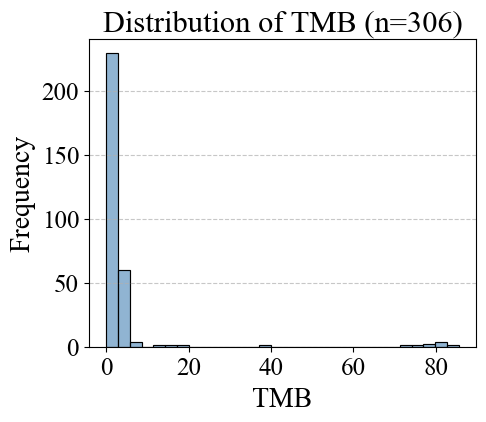

In [43]:
plot_distribution(TMB_df,column='TMB',save_path=".//TMB_distribution")

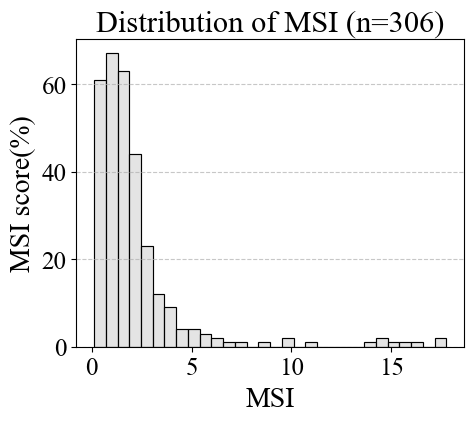

In [44]:
plot_distribution(msi_2,column='MSI',color='lightgrey',ylabel='MSI score(%)',save_path=".//MSI_distribution")